# Лабораторна робота №3. Класифікація твітів за тональністю з використанням Word2Vec та scikit-learn моделей

##### Завдання: побудувати класифікаційні моделі для прогнозування тональності твітів.

#### Хід роботи:
1. **Підготовка даних**
- Завантажуємо датасет
- Виконуємо попередню обробку тексту (очистка від стоп-слів, приведення до нижнього регістру, токенізація)
- Для кожного твіту формуємо вектор (наприклад, середнє арифметичне embedding-ів усіх слів у повідомленні)
- Ділимо дані на тренувальну та тестову вибірку

2. **Побудова моделей**
- Реалізовуємо scilit-learn pipeline, який включає: етап побудови ознак та етап класифікації
- Необхідно навчити та порівняти 4 моделі: Logistic Regression, Support Vector Machine(SVM), Random Forest, Naive Bayes

3. **Експеримент з PCA**
- Виконуємо класифікацію без зниження розмірності
- Виконуємо класифікацію після застосування PCA (наприклад, до 50, 100 та 200 компонент)
- Порівнюємо результати

4. **Метрики оцінки**
- Для оцінки моделей використовуємо: Accuracy, Precision, Recall, F1-score, Confusion Matrix
- Результати подаємо у вигляді таблиці: моделі х метрики х кількість компонент PCA



### Імпорт бібліотек
Підключаємо необхідні бібліотеки для обробки текстів, машинного навчання та візуалізації.

In [ ]:
# Імпорт бібліотек
import os
import re
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Налаштування відображення графіків
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Налаштування SSL для NLTK
Вимкнули SSL-перевірку для безпечного завантаження ресурсів NLTK та вказали локальну папку для зберігання даних NLP, що пришвидшує доступ до стоп-слів і токенізаторів.

In [ ]:
# Налаштування SSL для NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Налаштування шляху NLTK
NLTK_DATA_PATH = 'nltk_data'
if os.path.exists(NLTK_DATA_PATH):
    nltk.data.path.append(NLTK_DATA_PATH)
    print(f"✓ Використовується локальна папка nltk_data: {os.path.abspath(NLTK_DATA_PATH)}")
else:
    print("✗ Папка nltk_data не знайдена")

✗ Папка nltk_data не знайдена


### Перевірка ресурсів NLTK
Автоматично перевіряємо наявність необхідних NLP-ресурсів та завантажуємо їх у разі відсутності, що гарантує коректну роботу текстових процесів без ручного втручання.

In [ ]:
# Перевірка та завантаження NLTK ресурсів
print("Перевірка NLTK ресурсів...")

def check_nltk_data():
    """Перевіряє та завантажує необхідні NLTK ресурси"""
    resources = {
        'punkt': 'tokenizers/punkt',
        'stopwords': 'corpora/stopwords'
    }
    
    for resource_name, resource_path in resources.items():
        try:
            nltk.data.find(resource_path)
            print(f"✓ {resource_name} знайдено")
        except LookupError:
            print(f"Завантаження {resource_name}...")
            try:
                nltk.download(resource_name, quiet=True)
                print(f"✓ {resource_name} завантажено")
            except Exception as e:
                print(f"✗ Помилка завантаження {resource_name}: {e}")

check_nltk_data()

Перевірка NLTK ресурсів...
✓ punkt знайдено
✓ stopwords знайдено


In [ ]:
# Параметри експерименту
DATA_FILES = {
    'train': "Corona_NLP_train.csv",
    'test': "Corona_NLP_test.csv", 
    'single': "Corona_NLP.csv"
}

TEXT_COLUMNS = ["OriginalTweet", "Original Tweet", "OriginalTweet_text", "text", "tweet", "tweet_text"]
LABEL_COLUMNS = ["Sentiment", "Label", "label", "sentiment"]

EXPERIMENT_CONFIG = {
    'random_seed': 42,
    'test_ratio': 0.2,
    'embedding_dim': 100,
    'context_window': 5,
    'min_word_freq': 2,
    'training_epochs': 10,
    'pca_components_list': [None, 50, 100, 200]
}

print("Параметри експерименту налаштовано")

Параметри експерименту налаштовано


### Конфігурація експериментів
Визначаємо параметри дослідження: шляхи до датасетів, назви колонок з текстом та мітками, розмір векторів Word2Vec, параметри навчання та варіанти PCA для порівняння ефективності.

In [ ]:
# Завантаження стоп-слів
try:
    STOP_WORDS_SET = set(stopwords.words("english"))
    print(f"✓ Завантажено {len(STOP_WORDS_SET)} стоп-слів")
except Exception as e:
    print(f"✗ Не вдалося завантажити стоп-слова: {e}")
    # Резервний список стоп-слів
    STOP_WORDS_SET = {
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
        "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
        'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
        'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
        'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
        'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
        'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
        'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
        'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'
    }
    print(f"✓ Використовуються резервні стоп-слова ({len(STOP_WORDS_SET)} слів)")

✓ Завантажено 198 стоп-слів


### Функції обробки тексту
Реалізація очистки твітів, токенізації, створення векторів документів та стандартизації датасету для подальшого навчання моделей.

In [ ]:
# Функції обробки тексту
def clean_text_data(text_input):
    if not isinstance(text_input, str):
        return ""
    
    processed_text = text_input.lower()
    processed_text = re.sub(r"http\S+|www\.\S+", " ", processed_text)
    processed_text = re.sub(r"@\w+", " ", processed_text)
    processed_text = re.sub(r"#", " ", processed_text)
    processed_text = re.sub(r"[^a-zA-Z0-9\s']", " ", processed_text)
    processed_text = re.sub(r"\s+", " ", processed_text).strip()
    
    return processed_text

def tokenize_text_content(text_input):
    tokens = word_tokenize(str(text_input))
    filtered_tokens = [token for token in tokens 
                      if token.isalpha() and token not in STOP_WORDS_SET and len(token) > 1]
    return filtered_tokens

def create_document_vector(token_list, embedding_model, vector_size):
    word_vectors = [embedding_model.wv[word] for word in token_list if word in embedding_model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(vector_size, dtype=float)
    
    return np.mean(word_vectors, axis=0)

def find_dataset_columns(dataframe_columns, possible_names):
    for column_name in possible_names:
        if column_name in dataframe_columns:
            return column_name
    return None

def standardize_dataset_columns(dataframe):
    available_columns = dataframe.columns
    
    text_column = find_dataset_columns(available_columns, TEXT_COLUMNS)
    label_column = find_dataset_columns(available_columns, LABEL_COLUMNS)
    
    if text_column is None or label_column is None:
        text_candidate, label_candidate = None, None
        
        for column in available_columns:
            column_lower = column.lower()
            if text_candidate is None and ("tweet" in column_lower or "text" in column_lower):
                text_candidate = column
            if label_candidate is None and ("sent" in column_lower or "label" in column_lower):
                label_candidate = column
                
        if text_candidate is None or label_candidate is None:
            raise ValueError(f"Не знайдено текстову або цільову колонку. Доступні: {list(available_columns)}")
        
        text_column, label_column = text_candidate, label_candidate
    
    return dataframe[[text_column, label_column]].dropna().rename(
        columns={text_column: "text", label_column: "label"})

print("Функції обробки тексту готові")

Функції обробки тексту готові


### Завантаження даних
Автоматично визначаємо доступні файли датасету, завантажуємо тренувальну та тестову вибірки, стандартизуємо колонки та перевіряємо коректність завантажених даних перед подальшою обробкою.

In [ ]:
# Завантаження даних
print("Завантаження даних...")

def load_twitter_dataset():
    """Завантаження та підготовка датасету"""
    # Перевірка наявності файлів
    for file_type, file_name in DATA_FILES.items():
        if os.path.exists(file_name):
            print(f"✓ Знайдено {file_type}: {file_name}")
        else:
            print(f"✗ Не знайдено {file_type}: {file_name}")
    
    if os.path.exists(DATA_FILES['train']) and os.path.exists(DATA_FILES['test']):
        print("Завантаження окремих train/test файлів...")
        train_set = pd.read_csv(DATA_FILES['train'], encoding="latin1")
        test_set = pd.read_csv(DATA_FILES['test'], encoding="latin1")
    elif os.path.exists(DATA_FILES['single']):
        print("Завантаження єдиного файлу...")
        complete_dataset = pd.read_csv(DATA_FILES['single'], encoding="utf-8", errors="replace")
        complete_dataset = standardize_dataset_columns(complete_dataset)
        train_set, test_set = train_test_split(
            complete_dataset, 
            test_size=EXPERIMENT_CONFIG['test_ratio'], 
            random_state=EXPERIMENT_CONFIG['random_seed'], 
            stratify=complete_dataset["label"]
        )
    else:
        print("Файли не знайдені. Перевірте назви файлів.")
        return None, None
    
    train_set = standardize_dataset_columns(train_set)
    test_set = standardize_dataset_columns(test_set)
    
    return train_set, test_set

train_set, test_set = load_twitter_dataset()

if train_set is not None:
    print(f"Розмір тренувальних даних: {len(train_set)}")
    print(f"Розмір тестових даних: {len(test_set)}")
    print("\nПерші 3 рядки тренувальних даних:")
    print(train_set.head(3))
else:
    print("Не вдалося завантажити дані")

Завантаження даних...
✓ Знайдено train: Corona_NLP_train.csv
✓ Знайдено test: Corona_NLP_test.csv
✗ Не знайдено single: Corona_NLP.csv
Завантаження окремих train/test файлів...
Розмір тренувальних даних: 41157
Розмір тестових даних: 3798

Перші 3 рядки тренувальних даних:
                                                text     label
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral
1  advice Talk to your neighbours family to excha...  Positive
2  Coronavirus Australia: Woolworths to give elde...  Positive


### Нормалізація міток
Уніфікуємо різноманітні позначення тональності в три основні категорії (Positive, Negative, Other) для спрощення класифікації та аналізуємо розподіл цих категорій у датасеті.

In [ ]:
# Групування міток у три категорії
def group_sentiment_labels(label):
    """Групування міток у три основні категорії"""
    label_str = str(label).strip().lower()
    
    if label_str in ("positive", "pos", "p", "extremely positive"):
        return "Positive"
    if label_str in ("negative", "neg", "n", "extremely negative"):
        return "Negative"
    if "positive" in label_str:
        return "Positive"
    if "negative" in label_str:
        return "Negative"
    if label_str in ("neutral", "neut", "other", "mixed", "irrelevant", "normal"):
        return "Other"
    
    return "Other"

if train_set is not None:
    train_set["emotion_category"] = train_set["label"].apply(group_sentiment_labels)
    test_set["emotion_category"] = test_set["label"].apply(group_sentiment_labels)

    print("Розподіл категорій у тренувальних даних:")
    print(train_set["emotion_category"].value_counts())
    
    print("\nРозподіл категорій у тестових даних:")
    print(test_set["emotion_category"].value_counts())
else:
    print("Дані не завантажено")

Розподіл категорій у тренувальних даних:
emotion_category
Positive    18046
Negative    15398
Other        7713
Name: count, dtype: int64

Розподіл категорій у тестових даних:
emotion_category
Negative    1633
Positive    1546
Other        619
Name: count, dtype: int64


### Токенізація текстів
Очищаємо твіти, розбиваємо на токени з видаленням стоп-слів, фільтруємо порожні документи та аналізуємо результати попередньої обробки на прикладі конкретного твіту.

In [ ]:
# Токенізація текстів
if train_set is not None:
    print("Токенізація текстів...")

    # Очищення текстів
    train_set["processed_text"] = train_set["text"].apply(clean_text_data)
    test_set["processed_text"] = test_set["text"].apply(clean_text_data)

    def basic_tokenization(text_input):
        """Проста токенізація без NLTK"""
        if not isinstance(text_input, str):
            return []
        
        # Розділяємо по пробілах та фільтруємо
        tokens = text_input.split()
        filtered_tokens = [token for token in tokens 
                          if token.isalpha() and token not in STOP_WORDS_SET and len(token) > 1]
        return filtered_tokens

    print("Використання простої токенізації...")
    train_set["tokens"] = train_set["processed_text"].apply(basic_tokenization)
    test_set["tokens"] = test_set["processed_text"].apply(basic_tokenization)

    # Фільтрація порожніх документів
    original_train_size = len(train_set)
    original_test_size = len(test_set)

    train_set = train_set[train_set["tokens"].map(len) > 0].reset_index(drop=True)
    test_set = test_set[test_set["tokens"].map(len) > 0].reset_index(drop=True)

    print(f"Після фільтрації - тренувальні: {len(train_set)} (втрачено {original_train_size - len(train_set)})")
    print(f"Після фільтрації - тестові: {len(test_set)} (втрачено {original_test_size - len(test_set)})")

    # Перевірка розподілу після фільтрації
    print("\nРозподіл категорій після фільтрації:")
    print(train_set["emotion_category"].value_counts())
    
    print("\nПриклад токенізації:")
    sample_idx = 0
    for i in range(len(train_set)):
        if len(train_set.iloc[i]["tokens"]) > 0:
            sample_idx = i
            break
            
    sample_text = train_set.iloc[sample_idx]["text"]
    sample_cleaned = train_set.iloc[sample_idx]["processed_text"]
    sample_tokens = train_set.iloc[sample_idx]["tokens"]
    print(f"Оригінальний текст: {sample_text[:100]}...")
    print(f"Очищений текст: {sample_cleaned[:100]}...")
    print(f"Токени: {sample_tokens[:10]}...")
    print(f"Всього токенів: {len(sample_tokens)}")
else:
    print("Дані не завантажено")

Токенізація текстів...
Використання простої токенізації...
Після фільтрації - тренувальні: 41123 (втрачено 34)
Після фільтрації - тестові: 3796 (втрачено 2)

Розподіл категорій після фільтрації:
emotion_category
Positive    18044
Negative    15397
Other        7682
Name: count, dtype: int64

Приклад токенізації:
Оригінальний текст: advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbe...
Очищений текст: advice talk to your neighbours family to exchange phone numbers create contact list with phone numbe...
Токени: ['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list']...
Всього токенів: 27


### Навчання Word2Vec
Створюємо семантичні вектори слів, тренуючи модель на всіх токенах з твітів, зберігаємо результат та перевіряємо якість навчання через аналіз схожих слів та векторних представлень.

In [ ]:
# Навчання Word2Vec моделі
if train_set is not None:
    print("Навчання Word2Vec моделі...")

    # Підготовка всіх речень для тренування
    all_text_sequences = list(train_set["tokens"]) + list(test_set["tokens"])

    print(f"Загальна кількість речень для тренування: {len(all_text_sequences)}")
    print(f"Загальна кількість унікальних слів: {len(set([word for sentence in all_text_sequences for word in sentence]))}")

    # Навчання Word2Vec моделі
    embedding_model = Word2Vec(
        sentences=all_text_sequences,
        vector_size=EXPERIMENT_CONFIG['embedding_dim'],
        window=EXPERIMENT_CONFIG['context_window'],
        min_count=EXPERIMENT_CONFIG['min_word_freq'],
        workers=4,
        epochs=EXPERIMENT_CONFIG['training_epochs'],
        seed=EXPERIMENT_CONFIG['random_seed']
    )

    # Збереження моделі
    joblib.dump(embedding_model, "word_embedding_model.joblib")
    print(f"Word2Vec модель навчена. Розмір словника: {len(embedding_model.wv.index_to_key)}")

    # Перевірка якості векторів
    if len(embedding_model.wv.index_to_key) > 0:
        sample_word = embedding_model.wv.index_to_key[0]
        print(f"Приклад вектора для слова '{sample_word}': {embedding_model.wv[sample_word][:5]}...")
        
        # Пошук схожих слів
        if len(embedding_model.wv.index_to_key) > 10:
            test_word = embedding_model.wv.index_to_key[5]
            similar_words = embedding_model.wv.most_similar(test_word, topn=3)
            print(f"Слова схожі на '{test_word}': {similar_words}")
    else:
        print("Увага: модель не містить слів у словнику")
else:
    print("Дані не завантажено")

Навчання Word2Vec моделі...
Загальна кількість речень для тренування: 44919
Загальна кількість унікальних слів: 44433


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Word2Vec модель навчена. Розмір словника: 20933
Приклад вектора для слова 'coronavirus': [ 1.3106446  -0.6265786   1.2263178  -1.698055   -0.03169222]...
Слова схожі на 'supermarket': [('round', 0.6466600298881531), ('supermarkets', 0.5972838401794434), ('tesco', 0.5851311683654785)]


### Векторизація документів
Перетворюємо токенізовані твіти у числові вектори шляхом усереднення Word2Vec представлень слів, кодуємо текстові мітки в числові значення та формуємо фінальні матриці ознак для навчання моделей.

In [ ]:
# Створення векторних представлень документів
print("Створення векторних представлень...")

X_train_embeddings = np.vstack(
    train_set["tokens"].apply(
        lambda tokens: create_document_vector(tokens, embedding_model, EXPERIMENT_CONFIG['embedding_dim'])
    ).values
)

X_test_embeddings = np.vstack(
    test_set["tokens"].apply(
        lambda tokens: create_document_vector(tokens, embedding_model, EXPERIMENT_CONFIG['embedding_dim'])
    ).values
)

y_train_categories = train_set["emotion_category"].values
y_test_categories = test_set["emotion_category"].values

category_encoder = LabelEncoder()
y_train_numeric = category_encoder.fit_transform(y_train_categories)
y_test_numeric = category_encoder.transform(y_test_categories)

print("Кодування категорій:", dict(enumerate(category_encoder.classes_)))
print(f"Розмір тренувальних векторів: {X_train_embeddings.shape}")
print(f"Розмір тестових векторів: {X_test_embeddings.shape}")

Створення векторних представлень...
Кодування категорій: {0: 'Negative', 1: 'Other', 2: 'Positive'}
Розмір тренувальних векторів: (41123, 100)
Розмір тестових векторів: (3796, 100)


### Підготовка класифікаторів
Ініціалізуємо чотири алгоритми машинного навчання для порівняльного аналізу та створюємо функцію візуалізації матриці плутанини для оцінки якості класифікації.

In [ ]:
# Визначення класифікаторів та функцій візуалізації
classification_models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, 
        random_state=EXPERIMENT_CONFIG['random_seed']
    ),
    "LinearSVM": LinearSVC(
        random_state=EXPERIMENT_CONFIG['random_seed'],
        max_iter=10000
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        random_state=EXPERIMENT_CONFIG['random_seed']
    ),
    "GaussianNB": GaussianNB()
}

def plot_confusion_matrix(conf_matrix, class_names, title, filename=None, display=True):
    """Створення візуалізації матриці плутанини"""
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, 
                yticklabels=class_names, cmap="coolwarm", cbar=False)
    plt.ylabel("Реальні значення")
    plt.xlabel("Передбачені значення")
    plt.title(title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    if display:
        plt.show()
    else:
        plt.close()

print("Класифікатори та функції візуалізації готові")
print("Доступні моделі:", list(classification_models.keys()))

Класифікатори та функції візуалізації готові
Доступні моделі: ['LogisticRegression', 'LinearSVM', 'RandomForest', 'GaussianNB']


### Експерименти з PCA
Проводимо серію тестів, комбінуючи 4 моделі з різними конфігураціями PCA, обчислюємо метрики якості для кожної комбінації, зберігаємо навчені пайплайни та візуалізуємо матриці плутанини для аналізу помилок класифікації.

Початок експериментів з класифікацією...

Експеримент: Без_PCA
Навчання моделі: LogisticRegression з Без_PCA


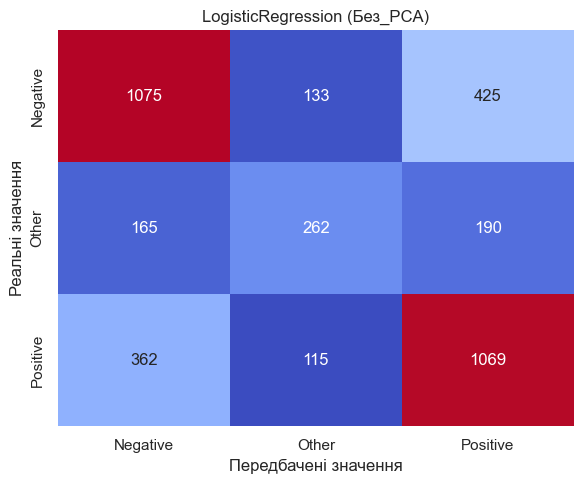

✓ LogisticRegression | Accuracy: 0.6338 | Збережено: classification_LogisticRegression_Без_PCA.joblib
Навчання моделі: LinearSVM з Без_PCA
✓ LinearSVM | Accuracy: 0.6359 | Збережено: classification_LinearSVM_Без_PCA.joblib
Навчання моделі: RandomForest з Без_PCA
✓ RandomForest | Accuracy: 0.6093 | Збережено: classification_RandomForest_Без_PCA.joblib
Навчання моделі: GaussianNB з Без_PCA
✓ GaussianNB | Accuracy: 0.5395 | Збережено: classification_GaussianNB_Без_PCA.joblib

Експеримент: PCA_50
Навчання моделі: LogisticRegression з PCA_50


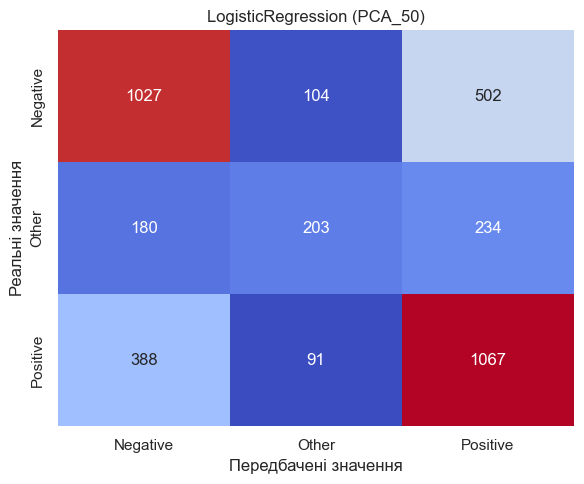

✓ LogisticRegression | Accuracy: 0.6051 | Збережено: classification_LogisticRegression_PCA_50.joblib
Навчання моделі: LinearSVM з PCA_50
✓ LinearSVM | Accuracy: 0.6046 | Збережено: classification_LinearSVM_PCA_50.joblib
Навчання моделі: RandomForest з PCA_50
✓ RandomForest | Accuracy: 0.6041 | Збережено: classification_RandomForest_PCA_50.joblib
Навчання моделі: GaussianNB з PCA_50
✓ GaussianNB | Accuracy: 0.5564 | Збережено: classification_GaussianNB_PCA_50.joblib

Експеримент: PCA_100
Навчання моделі: LogisticRegression з PCA_100


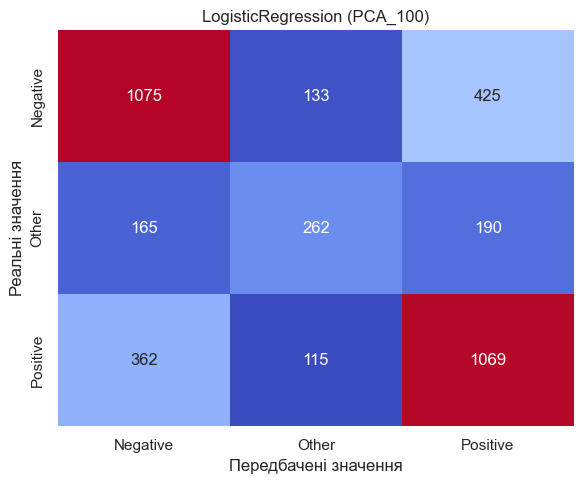

✓ LogisticRegression | Accuracy: 0.6338 | Збережено: classification_LogisticRegression_PCA_100.joblib
Навчання моделі: LinearSVM з PCA_100
✓ LinearSVM | Accuracy: 0.6359 | Збережено: classification_LinearSVM_PCA_100.joblib
Навчання моделі: RandomForest з PCA_100
✓ RandomForest | Accuracy: 0.6093 | Збережено: classification_RandomForest_PCA_100.joblib
Навчання моделі: GaussianNB з PCA_100
✓ GaussianNB | Accuracy: 0.5395 | Збережено: classification_GaussianNB_PCA_100.joblib

Експеримент: PCA_200
Навчання моделі: LogisticRegression з PCA_200


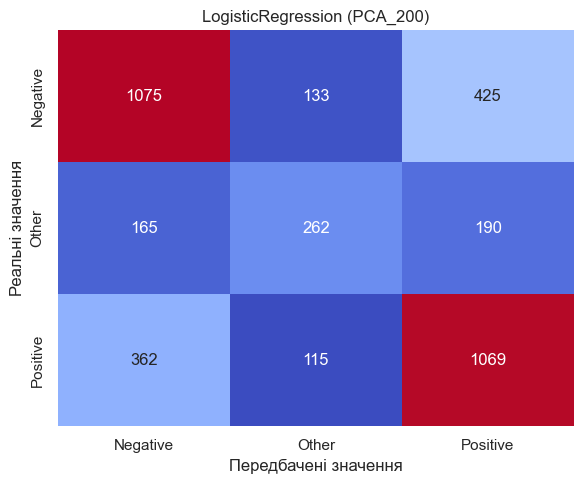

✓ LogisticRegression | Accuracy: 0.6338 | Збережено: classification_LogisticRegression_PCA_200.joblib
Навчання моделі: LinearSVM з PCA_200
✓ LinearSVM | Accuracy: 0.6359 | Збережено: classification_LinearSVM_PCA_200.joblib
Навчання моделі: RandomForest з PCA_200
✓ RandomForest | Accuracy: 0.6093 | Збережено: classification_RandomForest_PCA_200.joblib
Навчання моделі: GaussianNB з PCA_200
✓ GaussianNB | Accuracy: 0.5395 | Збережено: classification_GaussianNB_PCA_200.joblib

Експерименти завершено!


In [ ]:
# Експерименти з різними конфігураціями PCA
if train_set is not None and 'X_train_embeddings' in locals():
    print("Початок експериментів з класифікацією...")
    experiment_outcomes = []

    for pca_components in EXPERIMENT_CONFIG['pca_components_list']:
        pca_label = "Без_PCA" if pca_components is None else f"PCA_{pca_components}"
        
        print("\n" + "="*50)
        print(f"Експеримент: {pca_label}")
        print("="*50)
        
        for model_name, model_instance in classification_models.items():
            print(f"Навчання моделі: {model_name} з {pca_label}")
            
            try:
                pipeline_steps = []
                if pca_components is not None and X_train_embeddings.shape[1] > pca_components:
                    pipeline_steps.append(("pca", PCA(
                        n_components=min(pca_components, X_train_embeddings.shape[1]), 
                        random_state=EXPERIMENT_CONFIG['random_seed']
                    )))
                
                pipeline_steps.append(("classifier", model_instance))
                
                classification_pipeline = Pipeline(pipeline_steps)
                classification_pipeline.fit(X_train_embeddings, y_train_numeric)
                
                predictions = classification_pipeline.predict(X_test_embeddings)

                accuracy_value = accuracy_score(y_test_numeric, predictions)
                classification_metrics = classification_report(
                    y_test_numeric, predictions, 
                    target_names=category_encoder.classes_, 
                    output_dict=True, 
                    zero_division=0
                )
                
                conf_matrix_result = confusion_matrix(y_test_numeric, predictions)

                result_item = {
                    "класифікатор": model_name, 
                    "pca_компоненти": "None" if pca_components is None else pca_components, 
                    "accuracy": accuracy_value
                }
                
                for category in category_encoder.classes_:
                    category_stats = classification_metrics.get(category, {
                        "precision": 0, "recall": 0, "f1-score": 0, "support": 0
                    })
                    result_item[f"{category}_precision"] = category_stats["precision"]
                    result_item[f"{category}_recall"] = category_stats["recall"]
                    result_item[f"{category}_f1"] = category_stats["f1-score"]
                    result_item[f"{category}_support"] = category_stats.get("support", 0)
                
                experiment_outcomes.append(result_item)

                # Візуалізація для LogisticRegression
                if model_name == "LogisticRegression":
                    plot_confusion_matrix(
                        conf_matrix_result, 
                        class_names=category_encoder.classes_, 
                        title=f"{model_name} ({pca_label})", 
                        filename=None, 
                        display=True
                    )

                # Збереження моделі
                model_filename = f"classification_{model_name}_{pca_label}.joblib"
                joblib.dump(classification_pipeline, model_filename)
                
                print(f"✓ {model_name} | Accuracy: {accuracy_value:.4f} | Збережено: {model_filename}")
                
            except Exception as e:
                print(f"✗ Помилка у {model_name} з {pca_label}: {str(e)}")
                continue

    print("\nЕксперименти завершено!")
else:
    print("Дані не готові для експериментів")

### Збереження результатів
Формуємо таблицю з отриманими метриками, зберігаємо її у CSV-файл для подальшого аналізу та відображаємо результати всіх експериментів у структурованому вигляді.

In [ ]:
# Збереження результатів
results_df = pd.DataFrame(experiment_outcomes).sort_values(
    by=["класифікатор", "pca_компоненти"]).reset_index(drop=True)

results_df.to_csv("експериментальні_результати.csv", index=False)
print("Результати збережено у файл: експериментальні_результати.csv")

# Відображення результатів
print("\nОтримані результати:")
results_df

Результати збережено у файл: експериментальні_результати.csv

Отримані результати:


,класифікатор,pca_компоненти,accuracy,Negative_precision,Negative_recall,Negative_f1,Negative_support,Other_precision,Other_recall,Other_f1,Other_support,Positive_precision,Positive_recall,Positive_f1,Positive_support
0,GaussianNB,50,0.556375,0.586651,0.613595,0.599820,1633.0,0.386124,0.414911,0.400000,617.0,0.599298,0.552393,0.574891,1546.0
1,GaussianNB,100,0.539515,0.585190,0.546846,0.565369,1633.0,0.409449,0.421394,0.415335,617.0,0.547401,0.578913,0.562716,1546.0
2,GaussianNB,200,0.539515,0.585190,0.546846,0.565369,1633.0,0.409449,0.421394,0.415335,617.0,0.547401,0.578913,0.562716,1546.0
3,GaussianNB,None,0.539515,0.585190,0.546846,0.565369,1633.0,0.409449,0.421394,0.415335,617.0,0.547401,0.578913,0.562716,1546.0
4,LinearSVM,50,0.604584,0.638428,0.636865,0.637646,1633.0,0.546032,0.278768,0.369099,617.0,0.584773,0.700517,0.637434,1546.0
5,LinearSVM,100,0.635933,0.668101,0.665646,0.666871,1633.0,0.530752,0.377634,0.441288,617.0,0.632370,0.707633,0.667888,1546.0
6,LinearSVM,200,0.635933,0.668101,0.665646,0.666871,1633.0,0.530752,0.377634,0.441288,617.0,0.632370,0.707633,0.667888,1546.0
7,LinearSVM,None,0.635933,0.668101,0.665646,0.666871,1633.0,0.530752,0.377634,0.441288,617.0,0.632370,0.707633,0.667888,1546.0
8,LogisticRegression,50,0.605111,0.643887,0.628904,0.636307,1633.0,0.510050,0.329011,0.400000,617.0,0.591791,0.690168,0.637205,1546.0
9,LogisticRegression,100,0.633825,0.671036,0.658298,0.664606,1633.0,0.513725,0.424635,0.464951,617.0,0.634798,0.691462,0.661920,1546.0


### Аналіз впливу PCA
Створюємо лінійний графік для візуалізації залежності точності класифікації від кількості PCA компонент, що дозволяє порівняти ефективність різних моделей та визначити оптимальну розмірність ознакового простору.

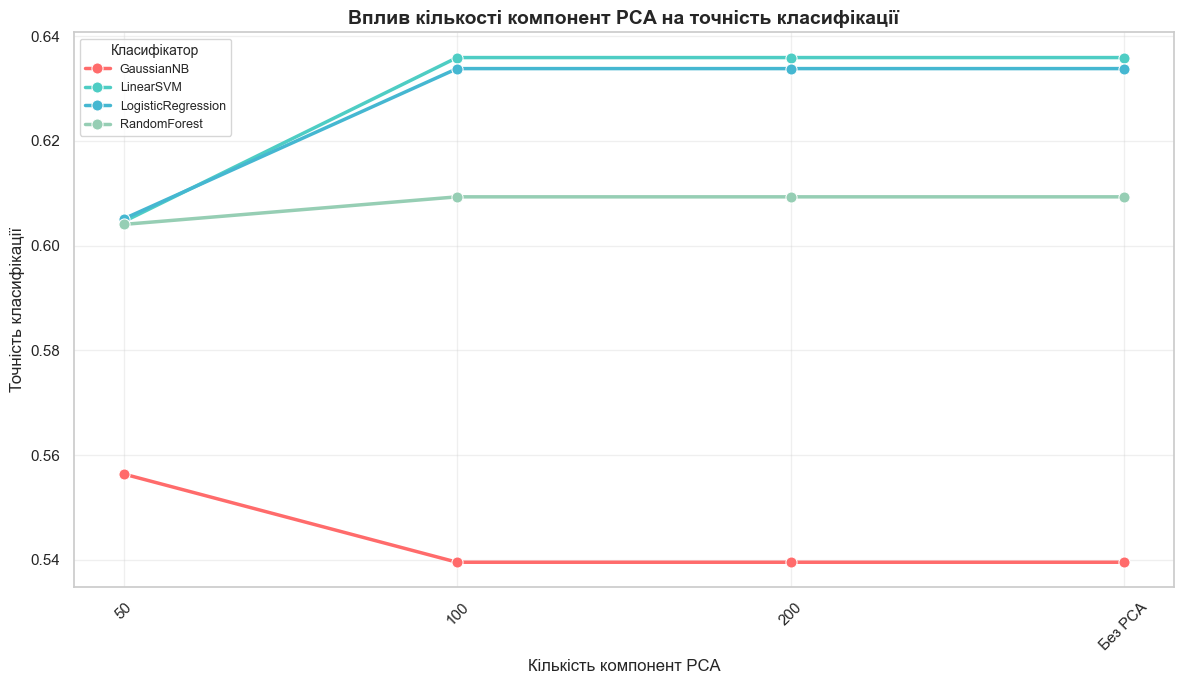

In [ ]:
# Візуалізація впливу PCA на точність
results_df['pca_visualization'] = results_df['pca_компоненти'].apply(
    lambda x: 'Без PCA' if x == 'None' else str(x))

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=results_df,
    x='pca_visualization', 
    y='accuracy', 
    hue='класифікатор', 
    marker='o',
    linewidth=2.5,
    markersize=8,
    palette=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
)

plt.title("Вплив кількості компонент PCA на точність класифікації", fontsize=14, fontweight='bold')
plt.xlabel("Кількість компонент PCA", fontsize=12)
plt.ylabel("Точність класифікації", fontsize=12)
plt.legend(title='Класифікатор', title_fontsize=10, fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Визначення найкращої моделі
Ідентифікуємо оптимальну комбінацію класифікатора та параметрів PCA з найвищою точністю, а також аналізуємо загальний вплив зниження розмірності на ефективність кожної з моделей.

In [ ]:
# Аналіз найкращих результатів
найкращий_експеримент = results_df.loc[results_df["accuracy"].idxmax()]

print("НАЙКРАЩА КОНФІГУРАЦІЯ:")
print(f"Модель: {найкращий_експеримент['класифікатор']}")
print(f"PCA: {найкращий_експеримент['pca_компоненти']}")
print(f"Точність: {найкращий_експеримент['accuracy']:.4f}")

# Аналіз впливу PCA на різні моделі
accuracy_no_pca = results_df[results_df["pca_компоненти"] == "None"].groupby("класифікатор")["accuracy"].mean()
accuracy_with_pca = results_df[results_df["pca_компоненти"] != "None"].groupby("класифікатор")["accuracy"].mean()

print("\nСЕРЕДНЯ ТОЧНІСТЬ БЕЗ PCA:")
print(accuracy_no_pca)

print("\nСЕРЕДНЯ ТОЧНІСТЬ З PCA:")
print(accuracy_with_pca)

НАЙКРАЩА КОНФІГУРАЦІЯ:
Модель: LinearSVM
PCA: 100
Точність: 0.6359

СЕРЕДНЯ ТОЧНІСТЬ БЕЗ PCA:
класифікатор
GaussianNB            0.539515
LinearSVM             0.635933
LogisticRegression    0.633825
RandomForest          0.609326
Name: accuracy, dtype: float64

СЕРЕДНЯ ТОЧНІСТЬ З PCA:
класифікатор
GaussianNB            0.545135
LinearSVM             0.625483
LogisticRegression    0.624254
RandomForest          0.607569
Name: accuracy, dtype: float64


### Порівняння моделей
Створюємо стовпчикову діаграму для візуального порівняння середньої ефективності всіх класифікаторів, використовуючи різні шаблони заливки та текстові анотації для кращої читабельності результатів.

ПОРІВНЯЛЬНА ХАРАКТЕРИСТИКА МОДЕЛЕЙ:


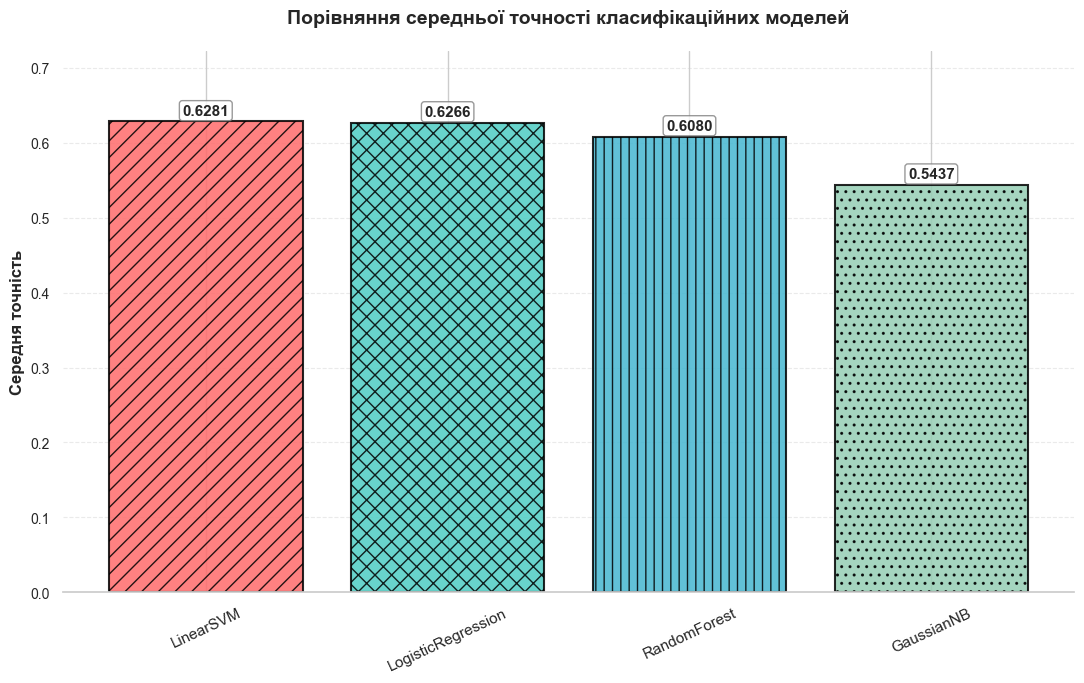


Рейтинг моделей за середньою точністю:
1. LinearSVM: 0.6281
2. LogisticRegression: 0.6266
3. RandomForest: 0.6080
4. GaussianNB: 0.5437


In [ ]:
# Порівняльний аналіз моделей
print("ПОРІВНЯЛЬНА ХАРАКТЕРИСТИКА МОДЕЛЕЙ:")

середня_ефективність = results_df.groupby('класифікатор')['accuracy'].mean().sort_values(ascending=False)

plt.figure(figsize=(11, 7))

# Створення стовпчиків з трохи іншим дизайном
bars = plt.bar(середня_ефективність.index, середня_ефективність.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
               alpha=0.85, edgecolor='black', linewidth=1.5,
               hatch=['//', 'xx', '||', '..'])

# Додавання значень на стовпці з трохи іншим стилем
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='gray', alpha=0.8))

# Налаштування осей та сітки
plt.ylabel('Середня точність', fontsize=12, fontweight='bold')
plt.ylim(0, max(середня_ефективність.values) * 1.15)
plt.xticks(rotation=25, fontsize=11)
plt.yticks(fontsize=10)

# Додавання горизонтальної сітки
plt.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)

# Оновлений заголовок
plt.title('Порівняння середньої точності класифікаційних моделей', 
          fontsize=14, fontweight='bold', pad=20)

# Поліпшення загального вигляду
sns.despine(left=True)
plt.tight_layout()

plt.show()

print("\nРейтинг моделей за середньою точністю:")
for i, (model, acc) in enumerate(середня_ефективність.items(), 1):
    print(f"{i}. {model}: {acc:.4f}")